<a href="https://colab.research.google.com/github/pgarg7/ATMS-597-SP-2020/blob/master/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Background

Imports and Installs

In [1]:
!pip install netcdf4
!pip install pydap
!pip install wget

%pylab inline 
import xarray as xr
import wget
import glob
from bs4 import BeautifulSoup
import requests
import pandas as pd
import datetime
import warnings
warnings.filterwarnings(action = "ignore", message = "^internal gelsd")

     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 317kB 45.2MB/s 
     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 122kB 46.0MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=be9d697ed29620021e9a8f2f6f543a618a70a33e8b20ad94bcbbd2ef8353b871
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Populating the interactive namespace from numpy and matplotlib


Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Define Functions

In [0]:
# Create a function to find months JJA
def is_jja(month):
    return (month >= 6) & (month <= 8)

Enter the directory in which you would be saving files and loading them.

In [0]:
YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS597/'

## Part 1:
Aggregate daily rainfall data from the Global Precipitaiton Climatology Project 1 degree daily precipitation data over the period 1996 - 2019 into a single file from daily files, available here: [https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/].

In [0]:
url = 'https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/'
ext = 'nc'

def get_url_paths(url, ext='', params={}):
    response = requests.get(url, params=params)
    if response.ok:
        response_text = response.text
    else:
        return response.raise_for_status()
    soup = BeautifulSoup(response_text, 'html.parser')
    parent = [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
    return parent

In [0]:
# Loop through all years and grab all of the datasets
years = np.arange(1996,2020)
datasets = []
for i in years:
  result = get_url_paths(url+'{i}/'.format(i=i),ext)
  print('working on {i} '.format(i=i))
  for j in range(len(result)):
    wget.download(result[j])
  files = glob.glob('gpcp*.nc')
  f = xr.open_mfdataset(files,concat_dim='time')
  var = xr.DataArray(f.precip.values,dims=['time','lat','lon'],
                    coords={'time':f.time.values,
                            'lat':f.latitude.values,
                            'lon':f.longitude.values})
  datasets.append(var)
  !rm gpcp*.nc
    #break

working on 1996 


KeyboardInterrupt: ignored

In [0]:
# Concatenate the datasets along time dimension
combined = xr.concat(datasets,dim='time')

# Convert to xarray dataset
combined_data = combined.to_dataset(name='precip')

# Convert to netCDF and save
combined_data.to_netcdf(YOUR_DIRECTORY + '/GPCP_aggregate.nc', format='NETCDF4')


## Part 2:
Determine the 95% values of daily precipitation during a selected particular 3-month period (given in the table below by group) over the grid box closest to the city you are examining. Plot a cumulative distribution function of all values daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

In [0]:
# Open the combined dataset
combined_data = xr.open_dataset(YOUR_DIRECTORY + 'GPCP_aggregate.nc')

In [0]:
# Slice data for June, July, and August only
jja_data = combined_data.sel(time=is_jja(combined_data['time.month']))

In [0]:
# Find data point: Shanghai, China lat, lon 31.2304° N, 121.4737° E
slat = 31.2304
slon = 121.4737

shanghai_jja = jja_data.sel(lon=slice(slon-.5,slon+.5),lat=slice(slat-.5,slat+.5))

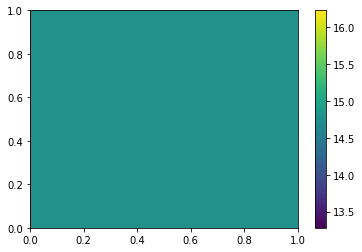

In [7]:
# Plot the Shanghai Precip values
plt.pcolormesh(shanghai_jja.precip.values[0,:,:])
plt.colorbar()
plt.show()

In [0]:
# Find valid values (remove obvious incorrect values)
valid_ind = np.where((shanghai_jja.precip.values>=0.)&(shanghai_jja.precip.values<=1000.))

In [0]:
# Extract valid values
precip_shanghai = shanghai_jja.precip.values[valid_ind]

In [0]:
# Calculate 95 percentile
perc_95 = np.percentile(precip_shanghai,95)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  from ipykernel import kernelapp as app


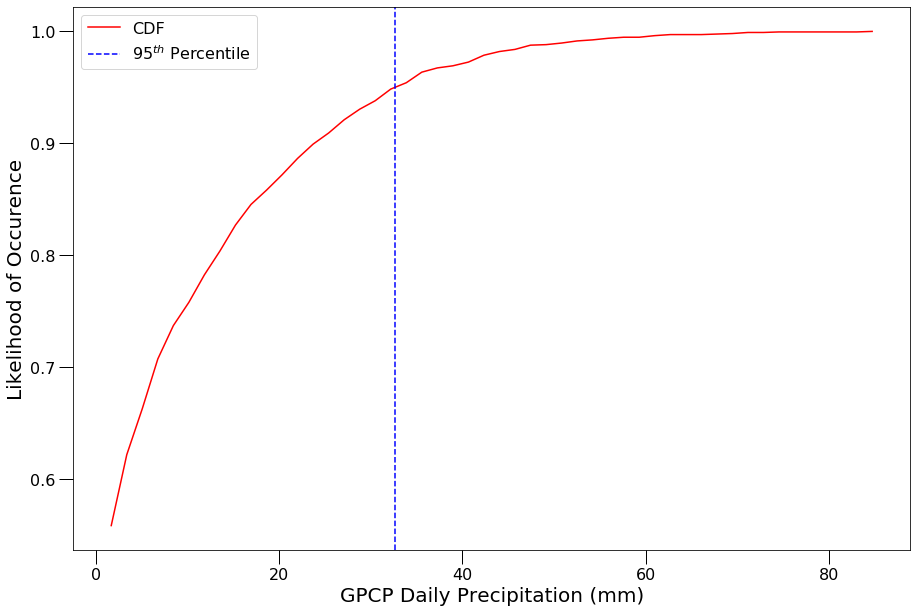

In [11]:
# Plot

# Plotting parameters
mpl.rcParams['xtick.major.size'] = 14
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 14
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 14
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 14
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif'] = ['Helvetica']
mpl.rc('xtick',labelsize=16)    # Formatting the x ticks
mpl.rc('ytick',labelsize=16)

# Plotting
counts, bin_edges = np.histogram (precip_shanghai, bins=50, normed=True)
cdf = np.cumsum (counts)
plt.figure(figsize=(15,10))
plt.plot (bin_edges[1:], cdf/cdf[-1],'r',label='CDF')
plt.axvline(perc_95,c='b',ls='--',label='$95^{th}$ Percentile')
plt.xlabel('GPCP Daily Precipitation (mm)',fontsize=20)
plt.ylabel('Likelihood of Occurence',fontsize=20)
plt.legend(loc='upper left',fontsize=16)
plt.show()

In [0]:
# Create Dataset for Shanghai significant points
shanghai_95th = shanghai_jja.where(shanghai_jja.precip>=perc_95,drop=True)

## Part 3:
Using output from the NCEP Reanalysis [https://journals.ametsoc.org/doi/pdf/10.1175/1520-0477(1996)077%3C0437%3ATNYRP%3E2.0.CO%3B2] (Kalnay et al. 1996), compute the global mean fields and seasonal anomaly fields for days meeting and exceeding the threshold of precipitation calculated in the previous step (using the 1981-2010 as a base period for anomalies) of

*   250 hPa wind vectors and wind speed,
*   500 hPa winds and geopotential height,
*   850 hPa temperature, specific humidity, and winds,
*   skin temperature, and surface winds,
*   total atmospheric column water vapor.

### Create functions to grab the data for all respective variables.
The first two functions grab the long term mean data (frequency: monthly) from 1981-2010. This is already derived in the NCEP Reanalysis datasets. These functions take in the arguments: variable (name) and level for the upper levels.

The second two functions grab the daily averaged data for a selected year. These functions take in the arguments: variable (name), year of interest, and level for the upper levels.

<b>Possible Variables</b><br>
Surface:
*    air_sfc
*    uwnd_sfc
*    vwnd_sfc
*    pr_wtr

Upper level:
*   uwnd
*   vwnd
*   wspd
*   hgt
*   air
*   shum

<i>These variables must be strings.</i>

In [0]:
# Season of JJA
JJA = [5, 6, 7]

# File strings for functions
filepath = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis'
fileperiod = '.1981-2010.ltm.nc'

def grab_LTM_data_sfc(variable):
    # Surface
    if variable == 'air_sfc':
        var = xr.open_dataset(filepath + '.derived/surface/air.sig995.mon' + str(fileperiod), engine='netcdf4').isel(nbnds=0)
    elif variable == 'uwnd_sfc':
        var = xr.open_dataset(filepath + '.derived/surface/uwnd.sig995.mon' + str(fileperiod), engine='netcdf4').isel(nbnds=0)
    elif variable == 'vwnd_sfc':
        var = xr.open_dataset(filepath + '.derived/surface/vwnd.sig995.mon' + str(fileperiod), engine='netcdf4').isel(nbnds=0)
    elif variable == 'pr_wtr':
        var = xr.open_dataset(filepath + '.derived/surface/pr_wtr.eatm.mon' + str(fileperiod), engine='netcdf4').isel(nbnds=0)
    else:
        print("Error. Please recheck argument inputs.")
    # Returns 2D Field
    return var

def grab_LTM_data(variable, lvl):
    var = xr.open_dataset(filepath + '.derived/pressure/' + str(variable) + '.mon'  + str(fileperiod), engine='netcdf4').isel(nbnds=0)
    x = var.sel(level=[lvl])
    # Returns 2D Field
    return x

def grab_yearly_data_sfc(variable, year):
    # Surface
    if variable == 'air_sfc':
        var = xr.open_dataset(filepath + '.dailyavgs/surface/air.sig995.' + str(year) + '.nc', engine='netcdf4')
    elif variable == 'uwnd_sfc':
        var = xr.open_dataset(filepath + '.dailyavgs/surface/uwnd.sig995.' + str(year) + '.nc', engine='netcdf4')
    elif variable == 'vwnd_sfc':
        var = xr.open_dataset(filepath + '.dailyavgs/surface/vwnd.sig995.' + str(year) + '.nc', engine='netcdf4')
    elif variable == 'pr_wtr':
        var = xr.open_dataset(filepath + '.dailyavgs/surface/pr_wtr.eatm.' + str(year) + '.nc', engine='netcdf4')
    else:
        print("Error. Please recheck argument inputs.")
    # Returns 2D Field
    return var

def grab_yearly_data(variable, lvl, year):
    var = xr.open_dataset(filepath + '.dailyavgs/pressure/' + str(variable) + '.' + str(year) + '.nc', engine='netcdf4')
    x = var.sel(level=[lvl])
    # Returns 2D Field
    return x

### Compute means
*   Long term seasonal mean
*   Extreme precip days mean
*   Seasonal anomalies mean

In [0]:
def calculate_means(variable, lvl, season):
    dataset = []
    dataset1 = []
    dataset2 = []
    t = pd.to_datetime(shanghai_95th.time.values)
    for i in range(len(shanghai_95th.time.values)):
          # Grab data for a specific year
          field = grab_yearly_data(variable, lvl, shanghai_95th.time.dt.year[i].values)

          # Select extreme precip day
          extreme = field.sel(time = field.time.dt.dayofyear == t[i].timetuple().tm_yday).squeeze()

          # Select seasonal long term mean
          ltm = grab_LTM_data(variable, lvl).isel(time=season).mean(dim='time').squeeze()

          # if variable == 'air': # Change from Celsius to Kelvin
          #   ####
          # elif variable == 'shum': # Change specific humidity from g/kg to kg/kg
          #   ####

          # Calculate anomaly
          anomaly = extreme[variable] - ltm[variable]

          # Append
          dataset.append(anomaly)
          dataset1.append(extreme[variable])
          dataset2.append(ltm[variable])

    anomalies = xr.concat(dataset, dim='index').mean(dim="index")
    extremes = xr.concat(dataset1, dim='index').mean(dim="index")
    ltms = xr.concat(dataset2, dim='index').mean(dim="index")
    return anomalies, extremes, ltms

def calculate_means_sfc(variable, season):
    dataset = []
    dataset1 = []
    dataset2 = []
    t = pd.to_datetime(shanghai_95th.time.values)
    for i in range(len(shanghai_95th.time.values)):
          # Grab data for a specific year
          field = grab_yearly_data_sfc(variable, shanghai_95th.time.dt.year[i].values)

          # Select extreme precip day
          extreme = field.sel(time = field.time.dt.dayofyear == t[i].timetuple().tm_yday).squeeze()

          # Select seasonal long term mean
          ltm = grab_LTM_data_sfc(variable).isel(time=season).mean(dim='time').squeeze()

          # if variable == 'air': # Change from Celsius to Kelvin
          #   ####

          # Calculate anomaly
          anomaly = extreme[variable] - ltm[variable]

          # Append
          dataset.append(anomaly)
          dataset1.append(extreme[variable])
          dataset2.append(ltm[variable])
          
    anomalies = xr.concat(dataset, dim='index').mean(dim="index")
    extremes = xr.concat(dataset1, dim='index').mean(dim="index")
    ltms = xr.concat(dataset2, dim='index').mean(dim="index")
    return anomalies, extremes, ltms


### Save anomalies to .nc file
Pick a level and variable to calculate. This saves the three anomalies to your directory of interest.

In [78]:
level = 250
variable = 'uwnd'
temp = calculate_means(variable, level, JJA)
which_mean = ['anomaly', 'extreme', 'ltm']
for a in range(len(temp)):
    combined_data = temp[a].to_dataset(name=variable)
    combined_data.to_netcdf(YOUR_DIRECTORY + str(variable) + '_' + str(level) + '_' + str(which_mean[a]) + '.nc', format='NETCDF4')


/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time ax

## Part 4:
Create maps showing the mean fields for the extreme precipitation day composites, long term mean composites for the selected months, and the anomaly fields for each variable. Use contours and vectors when appropriate.

In [0]:
# Import all of the necessary files
uwnd_250_anomaly = xr.open_dataset(YOUR_DIRECTORY + 'uwnd_250_anomaly.nc')
uwnd_250_extreme = xr.open_dataset(YOUR_DIRECTORY + 'uwnd_250_extreme.nc')
uwnd_250_ltm = xr.open_dataset(YOUR_DIRECTORY + 'uwnd_250_ltm.nc')

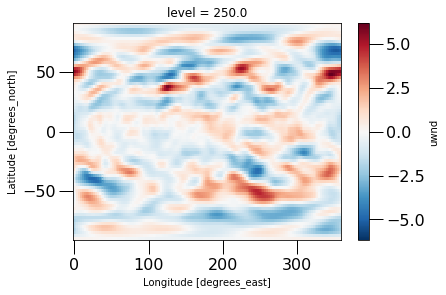

In [83]:
uwnd_250_anomaly['uwnd'].plot()

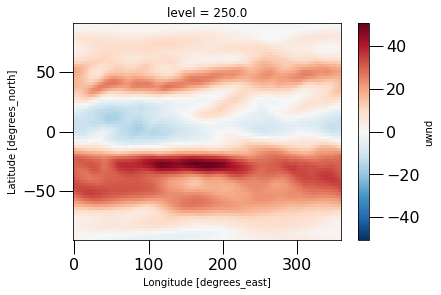

In [82]:
uwnd_250_extreme['uwnd'].plot()

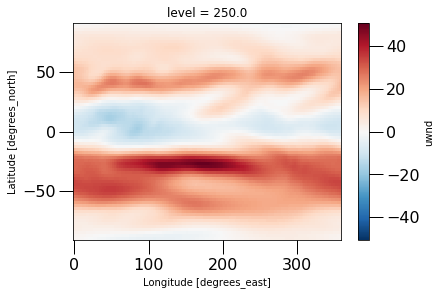

In [85]:
uwnd_250_ltm['uwnd'].plot()